I do Fisher exact tests on junctions we already know are alternatively spliced from short reads just to see what concordance looks like.

A few genes have p-values that aren't 1, however none have a value below 0.05. The x-axis is arbitrarily indexed.

In [13]:
setwd('~/bme')
wt_counts = read.table('junction_counts_long.wt.6.txt')
mt_counts = read.table('junction_counts_long.6.txt')
wt_counts$V1 = as.character(wt_counts$V1)
mt_counts$V1 = as.character(mt_counts$V1)
head(cbind(wt_counts, mt_counts))

V1,V2,V3,V4,V5,V1,V2,V3,V4,V5
PCK2,24099721,24099994,0,1,PCK2,24099721,24099994,2,1
PCK2,24099721,24102752,0,1,PCK2,24099721,24102752,1,1
"GOLGA6L5,RP11-182J1.12",84513303,84513966,0,1,"GOLGA6L5,RP11-182J1.12",84513303,84513966,0,1
"GOLGA6L5,RP11-182J1.12",84513331,84513966,0,1,"GOLGA6L5,RP11-182J1.12",84513331,84513966,0,1
DDHD2,38237628,38238106,0,1,DDHD2,38237628,38238106,0,1
DDHD2,38237628,38238088,1,1,DDHD2,38237628,38238088,0,1


In [15]:
current_gene = ''
genes = c()
pvals = c()  # for collecting results
sigrows = c()
for (row in 1:(nrow(wt_counts))+1) {  # looping through table and pulling out rows with shared gene names to do fisher tests on
    if (row == nrow(wt_counts)+1 || wt_counts[row, 1] != current_gene | nchar(current_gene)==0) {
        if (nchar(current_gene) > 0 && (nrow(wtinfo) > 1)) {
            for (i in 1:(nrow(wtinfo))) {
                for (j in i:nrow(wtinfo)) {
                    ctable = matrix(unlist(c(wtinfo[c(i,j),4], mtinfo[c(i,j),4])), nrow=2)
                    if (sum(ctable) != 0 && wtinfo[i,2] == wtinfo[j,2] | wtinfo[i,3] == wtinfo[j,3]) {  
                        # extra check for genes with multiple alt splice junctions, making sure gene and junction 5' end match
                        if (fisher.test(ctable)$p.value < 0.6) {
                            sigrows = c(sigrows, row-nrow(wtinfo)+i-1, row-nrow(wtinfo)+j-1)
                        }
                        pvals = c(pvals, fisher.test(ctable)$p.value)
                        genes = c(genes, current_gene)
                    }
                }
                
            }
        }
        current_gene = wt_counts[row, 1]
        wtinfo = wt_counts[row,]
        mtinfo = mt_counts[row,]
    } else {
        wtinfo = rbind(wtinfo, wt_counts[row,])
        mtinfo = rbind(mtinfo, mt_counts[row,])
    }
}

In [120]:
sigrows = sort(unique(sigrows))
head(cbind(wt_counts[sigrows,], mt_counts[sigrows,]))

,V1,V2,V3,V4,V5,V1,V2,V3,V4,V5
17,ERGIC3,35556272,35556990,0,1,ERGIC3,35556272,35556990,0,1
18,ERGIC3,35556749,35556954,0,1,ERGIC3,35556749,35556954,0,1
19,ERGIC3,35556272,35556954,0,1,ERGIC3,35556272,35556954,6,1
31,FKBP3,45130801,45134348,2,1,FKBP3,45130801,45134348,10,1
32,B3GAT3,62620672,62621865,0,1,B3GAT3,62620672,62621865,4,1
40,SRSF11,70228556,70232267,2,1,SRSF11,70228556,70232267,12,1


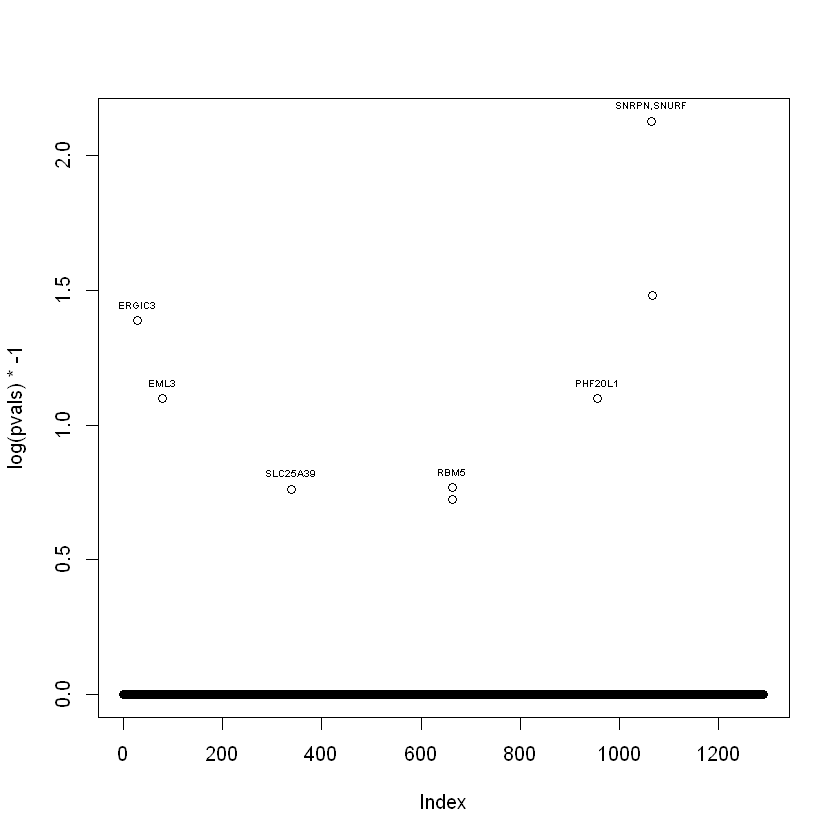

In [16]:
plot(log(pvals)*-1)
df = data.frame(g=genes, p=pvals)
df$pos = 1:nrow(df)
df = df[df$p < 0.6,]
newdf = df[1,]
for (row in 2:nrow(df)) {
    if (!df[row,1] %in% newdf[,1]) {
        newdf = rbind(newdf, df[row,])
    } else if (any((df[row,2]+.01) <= newdf[newdf$g == df[row,1],2])) {
        newdf = rbind(newdf, df[row,])
    }
}
text(newdf$pos, log(newdf$p)*-1+.06, labels=newdf$g, cex=0.5)  # names above points
abline(h=log2(0.05))

I use Jeltje's bedfile of corrected junctions and the junction counts in there and do lots of fisher tests. I'm looking specifically at 3' SS alterations, so I compare counts for different 3' SSs in the mutant and wildtype for junctions with the same 5' SS. Jeltje mentioned that the strand doesn't carry meaning in her bedfile, so I repeat this analysis treating "3'" as 5' SSs.

In [21]:
setwd('~/bme')
mtalt = read.table('altsplicejunction_counts.txt')
colnames(mtalt) = c('mtchrom', 'mt5', 'mt3', 'counts')
wtalt = read.table('altsplicejunction_counts.wt.txt')
together = mtalt
together$wt = wtalt$V4[match(mtalt$mt5, wtalt$V2)]
together$wtchrom = wtalt$V1[match(mtalt$mt5, wtalt$V2)]  # sanity check
together$mtchrom = as.character(together$mtchrom)
together$wtchrom = as.character(together$wtchrom)
together = together[!is.na(together$wt) & together$wtchrom == together$mtchrom,]
head(together)  # data frame containing junction counts for both mutant and wildtype

,mtchrom,mt5,mt3,counts,wt,wtchrom
20,chrY,1389707,1391934,1,10,chrY
21,chrY,1389707,1391947,1,10,chrY
22,chrY,1389707,1391918,54,10,chrY
78,chrX,154399376,154399527,1,1,chrX
79,chrX,154399376,154399520,5,1,chrX
80,chrX,154399376,154399506,101,1,chrX


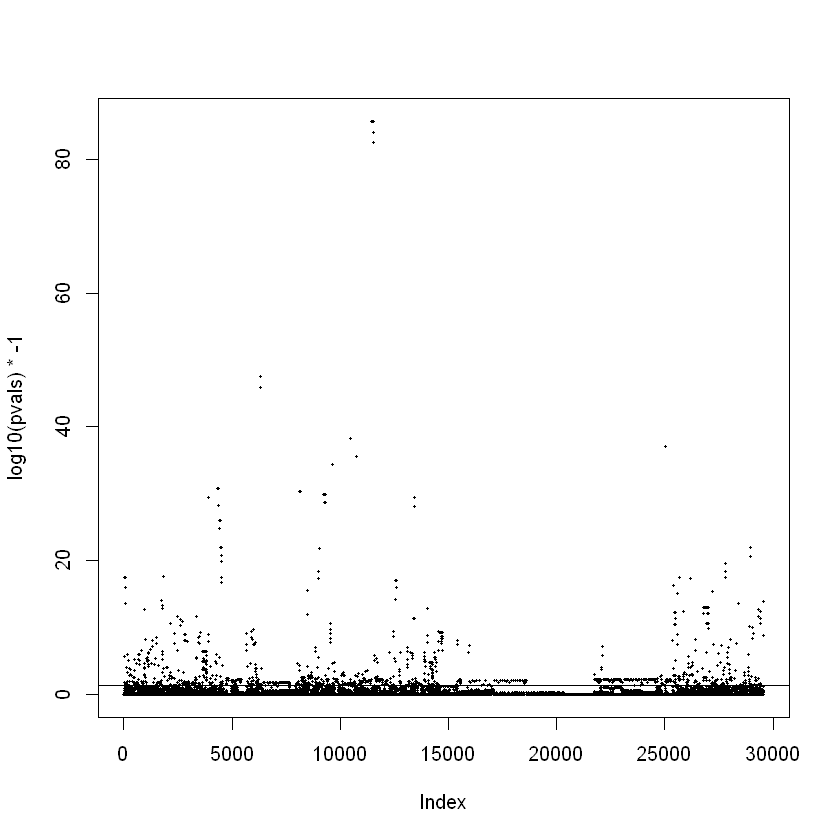

In [15]:
current_gene = paste0(together[1,1],':',together[1,2])
info = together[1,]
genes = c()
pvals = c()
for (row in 2:nrow(together)) {
    nameinit = paste0(together[row,1],':',together[row, 2])
    if (nameinit != current_gene) {
        for (i in 1:(nrow(info)-1)) {
            for (j in (i+1):nrow(info)) {
                ctable = matrix(unlist(c(info[c(i,j),4], info[c(i,j),5])), nrow=2)
                if (sum(ctable) != 0) {
                    pvals = c(pvals, fisher.test(ctable)$p.value)
                    genes = c(genes, current_gene)
                }
            }    
        }
        current_gene = nameinit
        info = together[row,]
    } else {
        info = rbind(info, together[row,])
    }
}
rgenes = genes[pvals < 0.2]
rpvals = pvals[pvals < 0.2]
plot(log10(pvals)*-1, pch=16, cex=0.3)
# text(1:length(rpvals), log10(rpvals)*-1+.03, labels=rgenes, cex=0.5)  # names above points
abline(h=log10(0.05)*-1)


Above: every point is the result of one fisher test between alternative junction events. These are only considering 3' splice site alterations, so if you look at the the mutant 5' position column (together$mt5), comparisons are done within a group of junctions sharing the same 5' end.

Below: Like the plot above, but instead anchoring at the 3' ends. Some of these junctions could still be technically 5' end-anchored since Jeltje said the counts were done without regard to strand and the bedfile of junctions does not have strand information.

,mtchrom,mt5,mt3,counts,wt,wtchrom
27843,chr9,18467,24870,1,1,chr9
27844,chr9,24618,24870,1,1,chr9
27845,chr9,18472,24870,3,1,chr9
2082,chr12,18459,26820,1,1,chr12
2083,chr12,18464,26820,3,1,chr12
2084,chr12,26568,26820,1,1,chr12


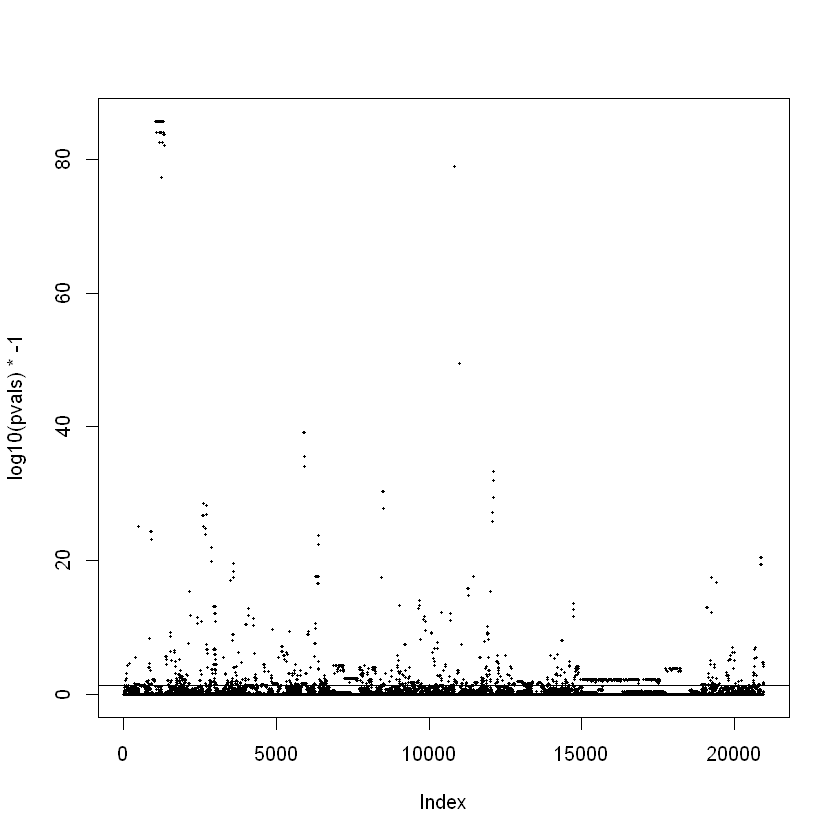

In [12]:
setwd('~/bme')
mtalt = read.table('altsplicejunction_counts.3.txt')   # anchored at the 3' site, aka the greater junction coordinate
colnames(mtalt) = c('mtchrom', 'mt5', 'mt3', 'counts')
wtalt = read.table('altsplicejunction_counts.3.wt.txt')
together = mtalt
together$wt = wtalt$V4[match(mtalt$mt3, wtalt$V3)]
together$wtchrom = wtalt$V1[match(mtalt$mt3, wtalt$V3)]  # sanity check
together$mtchrom = as.character(together$mtchrom)
together$wtchrom = as.character(together$wtchrom)
together = together[order(together$mt3),]
together = together[!is.na(together$wt) & together$wtchrom == together$mtchrom,]
head(together)  # data frame containing junction counts for both mutant and wildtype
current_gene = paste0(together[1,1],':',together[1,3])
info = together[1,]
genes = c()
pvals = c()
for (row in 2:nrow(together)) {
    nameinit = paste0(together[row,1],':',together[row, 3])
    if (nameinit != current_gene) {
        for (i in 1:(nrow(info)-1)) {
            for (j in (i+1):nrow(info)) {
                ctable = matrix(unlist(c(info[c(i,j),4], info[c(i,j),5])), nrow=2)
                if (sum(ctable) != 0) {
                    pvals = c(pvals, fisher.test(ctable)$p.value)
                    genes = c(genes, current_gene)
                }
            }    
        }
        current_gene = nameinit
        info = together[row,]
    } else {
        info = rbind(info, together[row,])
    }
}
rgenes = genes[pvals < 0.2]
rpvals = pvals[pvals < 0.2]
plot(log10(pvals)*-1, pch=16, cex=0.3)
abline(h=log10(0.05)*-1)


<b> From here on starts analysis that actually makes sense :D </b> <br>
Jeltje modified her script to be able to take in a genome and infer strand. So now I am plotting alternative 3' splice sites that are really 3' splice sites being altered.

In [ ]:
setwd('~/bme/jupyter_data')
mtalt = read.table('altsplicejunction_counts.txt')
mtaltrev = read.table('altsplicejunction_counts.rev.txt')  # 3' ss alterations on the minus strand
colnames(mtalt) = c('mtchrom', 'mt5', 'mt3', 'mtcounts')
colnames(mtaltrev) = c('mtchrom', 'mt5', 'mt3', 'mtcounts')
wtalt = read.table('alt3primess_counts.wt.txt')
wtaltrev = read.table('alt3primess_counts.wt.rev.txt')

wtaltrev$temp = wtaltrev[,2]
wtaltrev[,2] = wtaltrev[,3]
wtaltrev[,3] = wtaltrev$temp

mtaltrev$temp = mtaltrev[,2]
mtaltrev[,2] = mtaltrev[,3]
mtaltrev[,3] = mtaltrev$temp

alljuncs = unique(c(paste0(mtalt[,2],'-',mtalt[,3]), paste0(wtalt[,2],'-', wtalt[,3]), paste0(mtaltrev[,2],'-',mtaltrev[,3]),
             paste0(wtaltrev[,2],'-',wtaltrev[,3])))
junctions = data.frame(alljuncs)
junctions$intron5 = as.numeric(substr(alljuncs,1,regexpr('-', alljuncs)-1))
junctions$intron3 = as.numeric(substr(alljuncs,regexpr('-',alljuncs)+1,nchar(alljuncs)))
wtcounts = wtalt[,4][match(alljuncs, paste0(wtalt[,2],'-',wtalt[,3]))]
wtcounts[is.na(wtcounts)] = wtaltrev[,4][match(alljuncs, paste0(wtaltrev[,2],'-',wtaltrev[,3]))][is.na(wtcounts)]
junctions$wtcounts = wtcounts
junctions$wtcounts[is.na(junctions$wtcounts)] = 0

mtcounts = mtalt[,4][match(alljuncs, paste0(mtalt[,2],'-',mtalt[,3]))]
mtcounts[is.na(mtcounts)] = mtaltrev[,4][match(alljuncs, paste0(mtaltrev[,2],'-',mtaltrev[,3]))][is.na(mtcounts)]
junctions$mtcounts = mtcounts
junctions$mtcounts[is.na(junctions$mtcounts)] = 0

chrvec =  wtalt[,1][match(alljuncs, paste0(wtalt[,2],'-',wtalt[,3]))]
chrvec[is.na(chrvec)] = wtaltrev[,1][match(alljuncs, paste0(wtaltrev[,2],'-',wtaltrev[,3]))][is.na(chrvec)]
chrvec[is.na(chrvec)] = mtalt[,1][match(alljuncs, paste0(mtalt[,2],'-',mtalt[,3]))][is.na(chrvec)]
chrvec[is.na(chrvec)] = mtaltrev[,1][match(alljuncs, paste0(mtaltrev[,2],'-',mtaltrev[,3]))][is.na(chrvec)]
junctions$chr = chrvec
junctions = junctions[!is.na(chrvec) & rowSums(junctions[,c(4,5)]) > 1,]  # 2 is the min number of reads between both samples

junctions = junctions[order(junctions[,2]),]
junctions[,5] = round(sum(junctions[,4])/sum(junctions[,5])*junctions[,5])

junctions[1:6,]  # data frame containing junction counts for both mutant and wildtype

current_gene = paste0(junctions[1,6],':',junctions[1,2])
info = junctions[1,]
genes = c()
pvals = c()
dpsi = c()
allpvals = c()
for (row in 2:nrow(junctions)) {
    nameinit = paste0(junctions[row,6],':',junctions[row, 2])
    if (nameinit != current_gene ) {
        if (nrow(info) > 1) {
            best_dpsi = 0
            best_pval = 1
            for (i in 1:(nrow(info)-1)) {
                for (j in (i+1):nrow(info)) {
                    ctable = matrix(unlist(c(info[c(i,j),4], info[c(i,j),5])), nrow=2)
                    if (sum(ctable) != 0) {
                        pval = fisher.test(ctable)$p.value
                        allpvals = c(allpvals, pval)
                        if (pval < best_pval) {
                            best_pval = pval
                            best_dpsi = abs(info[i, 4]/sum(info[c(i,j),4]) - info[i, 5]/sum(info[c(i,j),5]))
                        }
                    }
                }
            }
            genes = c(genes, current_gene)
            pvals = c(pvals, best_pval)
            dpsi = c(dpsi, best_dpsi)
        }
        current_gene = nameinit
        info = junctions[row,]
    } else {
        info = rbind(info, junctions[row,])
    }
}
plot(log10(pvals)*-1, pch=16, cex=0.3, main="Alt 3'SS")
abline(h=log10(0.05)*-1)

genes3 = genes
pvals3 = allpvals
junctions3 = junctions
dpsi3=dpsi

Warning message in `[<-.factor`(`*tmp*`, is.na(chrvec), value = structure(c(NA, :
"invalid factor level, NA generated"Warning message in `[<-.factor`(`*tmp*`, is.na(chrvec), value = structure(c(24L, :
"invalid factor level, NA generated"Warning message in `[<-.factor`(`*tmp*`, is.na(chrvec), value = structure(c(NA, :
"invalid factor level, NA generated"

,alljuncs,intron5,intron3,wtcounts,mtcounts,chr
8736,51577-47537,51577,47537,0,2,chr16
16572,123236-122070,123236,122070,2,2,chr9
16706,134998-123434,134998,123434,0,1,chr9
16429,154728-152058,154728,152058,0,2,chr9
16638,172100-168892,172100,168892,1,0,chr9
16639,172100-164017,172100,164017,2,2,chr9


I plot altered 5' splice sites that are actually altered 5' splice sites. It's a bit interesting to compare this plot and the plot above with the previous two plots above that. It's all the same points just now they're correctly categorized.

,alljuncs,intron5,intron3,wtcounts,mtcounts,chr
965,51577-47537,51577,47537,0,2,chr16
8070,55529-55796,55529,55796,0,2,chr16
8256,56593-57105,56593,57105,0,2,chr16
7979,83236-85420,83236,85420,0,1,chr16
4713,121980-121553,121980,121553,2,0,chr9
3236,146121-135010,146121,135010,2,2,chr9


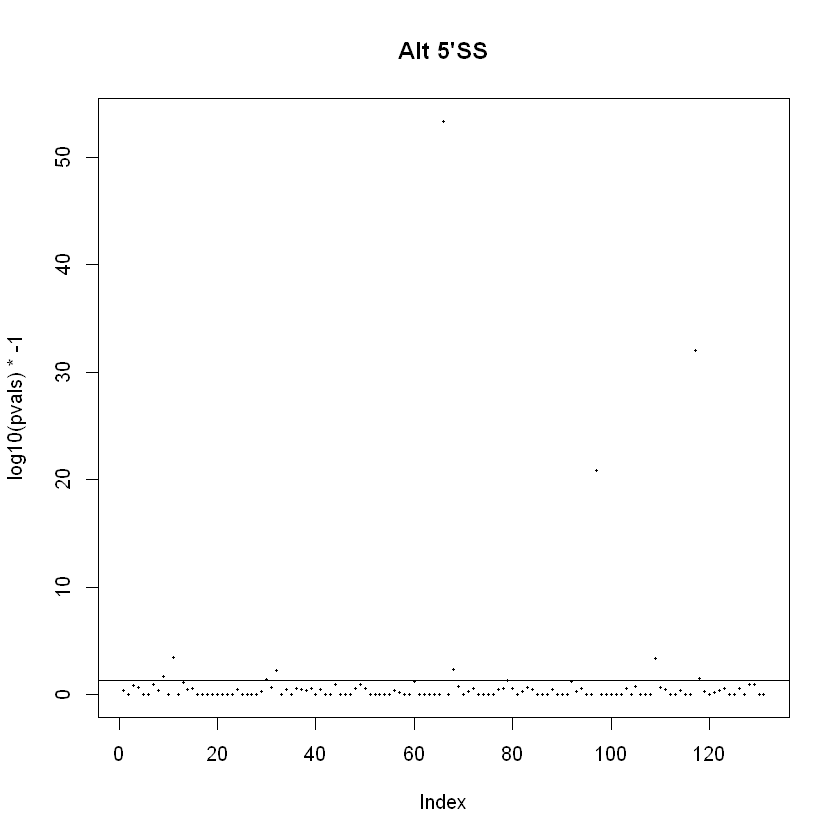

In [9]:
setwd('~/bme/jupyter_data')
mtaltrev = read.table('alt5primess_counts.txt')
mtalt = read.table('alt5primess_counts.rev.txt')  # 3' ss alterations on the minus strand
colnames(mtalt) = c('mtchrom', 'mt5', 'mt3', 'mtcounts')
colnames(mtaltrev) = c('mtchrom', 'mt5', 'mt3', 'mtcounts')
wtaltrev = read.table('alt5primess_counts.wt.txt')
wtalt = read.table('alt5primess_counts.wt.rev.txt')

wtalt$temp = wtalt[,2]  # switch columns just so I can reuse 3' alt ss code
wtalt[,2] = wtalt[,3]
wtalt[,3] = wtalt$temp

mtalt$temp = mtalt[,2]
mtalt[,2] = mtalt[,3]
mtalt[,3] = mtalt$temp

alljuncs = unique(c(paste0(mtalt[,2],'-',mtalt[,3]), paste0(wtalt[,2],'-', wtalt[,3]), paste0(mtaltrev[,2],'-',mtaltrev[,3]),
             paste0(wtaltrev[,2],'-',wtaltrev[,3])))
junctions = data.frame(alljuncs)
junctions$intron5 = as.numeric(substr(alljuncs,1,regexpr('-', alljuncs)-1))
junctions$intron3 = as.numeric(substr(alljuncs,regexpr('-',alljuncs)+1,nchar(alljuncs)))
wtcounts = wtalt[,4][match(alljuncs, paste0(wtalt[,2],'-',wtalt[,3]))]
wtcounts[is.na(wtcounts)] = wtaltrev[,4][match(alljuncs, paste0(wtaltrev[,2],'-',wtaltrev[,3]))][is.na(wtcounts)]
junctions$wtcounts = wtcounts
junctions$wtcounts[is.na(junctions$wtcounts)] = 0

mtcounts = mtalt[,4][match(alljuncs, paste0(mtalt[,2],'-',mtalt[,3]))]
mtcounts[is.na(mtcounts)] = mtaltrev[,4][match(alljuncs, paste0(mtaltrev[,2],'-',mtaltrev[,3]))][is.na(mtcounts)]
junctions$mtcounts = mtcounts
junctions$mtcounts[is.na(junctions$mtcounts)] = 0

chrvec =  wtalt[,1][match(alljuncs, paste0(wtalt[,2],'-',wtalt[,3]))]
chrvec[is.na(chrvec)] = wtaltrev[,1][match(alljuncs, paste0(wtaltrev[,2],'-',wtaltrev[,3]))][is.na(chrvec)]
chrvec[is.na(chrvec)] = mtalt[,1][match(alljuncs, paste0(mtalt[,2],'-',mtalt[,3]))][is.na(chrvec)]
chrvec[is.na(chrvec)] = mtaltrev[,1][match(alljuncs, paste0(mtaltrev[,2],'-',mtaltrev[,3]))][is.na(chrvec)]
junctions$chr = chrvec
junctions = junctions[!is.na(chrvec) & rowSums(junctions[,c(4,5)]) > 1,]

junctions = junctions[order(junctions[,2]),]
junctions[,5] = round(sum(junctions[,4])/sum(junctions[,5])*junctions[,5])

junctions[1:6,]  # data frame containing junction counts for both mutant and wildtype

current_gene = paste0(junctions[1,6],':',junctions[1,2])
info = junctions[1,]
genes = c()
pvals = c()
allpvals = c()
dpsi = c()
for (row in 2:nrow(junctions)) {
    nameinit = paste0(junctions[row,6],':',junctions[row, 2])
    if (nameinit != current_gene ) {
        if (nrow(info) > 1) {
            best_dpsi = 0
            best_pval = 1
            for (i in 1:(nrow(info)-1)) {
                for (j in (i+1):nrow(info)) {
                    ctable = matrix(unlist(c(info[c(i,j),4], info[c(i,j),5])), nrow=2)
                    if (sum(ctable) != 0) {
                        pval = fisher.test(ctable)$p.value
                        allpvals = c(allpvals, pval)
                        if (pval < best_pval) {
                            best_pval = pval
                            best_dpsi = abs(info[i, 4]/sum(info[c(i,j),4]) - info[i, 5]/sum(info[c(i,j),5]))
                        }
                    }
                }
            }
            genes = c(genes, current_gene)
            pvals = c(pvals, best_pval)
            dpsi = c(dpsi, best_dpsi)
        }
        current_gene = nameinit
        info = junctions[row,]
    } else {
        info = rbind(info, junctions[row,])
    }
}
plot(log10(pvals)*-1, pch=16, cex=0.3, main="Alt 5'SS")
abline(h=log10(0.05)*-1)

genes5 = genes
pvals5 = allpvals
junctions5 = junctions
dpsi5=dpsi

There are more unique significant Alt3'SS than Alt5'SS events with and without FDR correction. <br>

In [7]:
length(unique(pvals5[pvals5<0.05]))  # number of significant alt 5'ss events
length(unique(pvals3[pvals3<0.05]))  # number of significant alt 3'ss events
pvals5adj = p.adjust(pvals5, method='fdr')
pvals3adj = p.adjust(pvals3, method='fdr')
length(unique(pvals5adj[pvals5adj<0.05]))  # number of significant alt 5' ss events after fdr correction
length(unique(pvals3adj[pvals3adj<0.05]))  # number of significant alt 3' ss events after fdr connection
length(unique(paste0(junctions5[,1],junctions5[,3])))  # number of alt 5' ss events
length(unique(paste0(junctions3[,1], junctions3[,2])))  # number of alt 3' ss events
df3 = data.frame(genes3, pvals3adj)
df5 = data.frame(genes5, pvals5adj)
cbind((df3[order(df3$pvals3adj),][1:25,]), data.frame(index=seq(1:50)), (df5[order(df5$pvals5adj),][1:50,]))

[1] 11

[1] 10

[1] 4

[1] 7

[1] 8032

[1] 7974

Warning message in data.frame(..., check.names = FALSE):
"row names were found from a short variable and have been discarded"

genes3,pvals3adj,index,genes5,pvals5adj
chr14:105855499,7.649873e-19,1,chr19:48965896,5.958814e-52
chr9:19378727,4.824745e-18,2,chr5:150412644,6.413365e-31
chr19:48965896,1.280741e-15,3,chr14:105855499,6.719453e-20
chr5:150412644,1.116605e-10,4,chr10:3781660,1.077746e-02
chr6:24718559,4.029550e-03,5,chr7:142801407,1.077746e-02
chr5:150446821,9.494452e-03,6,chr12:53295619,9.012728e-02
chr6:158770783,3.280996e-02,7,chr1:30757678,1.094403e-01
chr9:172100,1.000000e+00,8,chr19:2269724,3.023077e-01
chr11:209980,1.000000e+00,9,chr5:150445628,4.851852e-01
chr11:212491,1.000000e+00,10,chr6:30490495,5.103896e-01


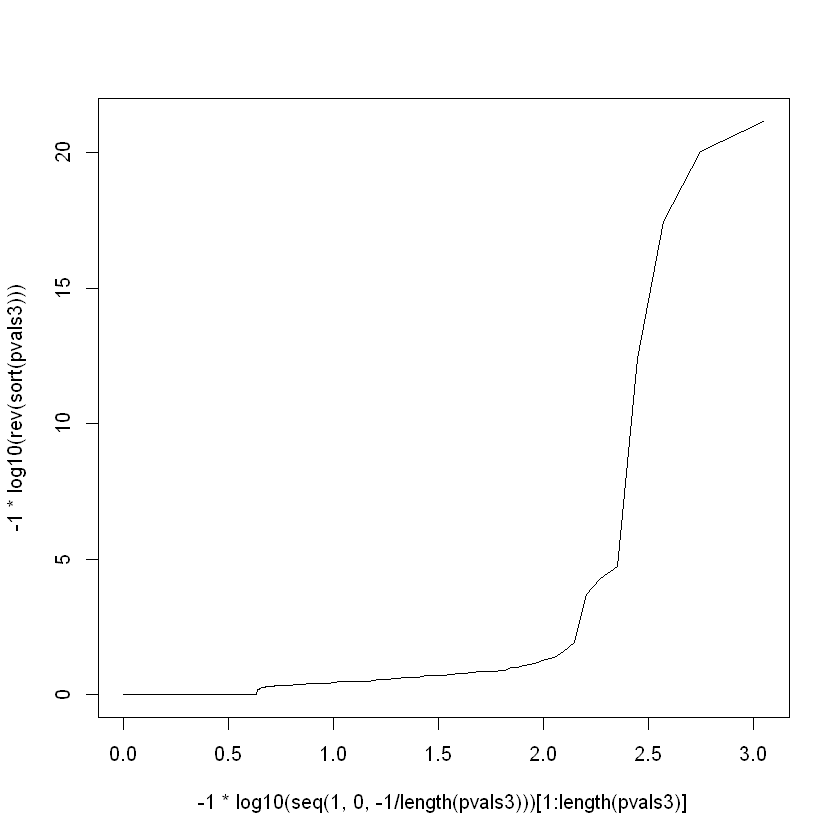

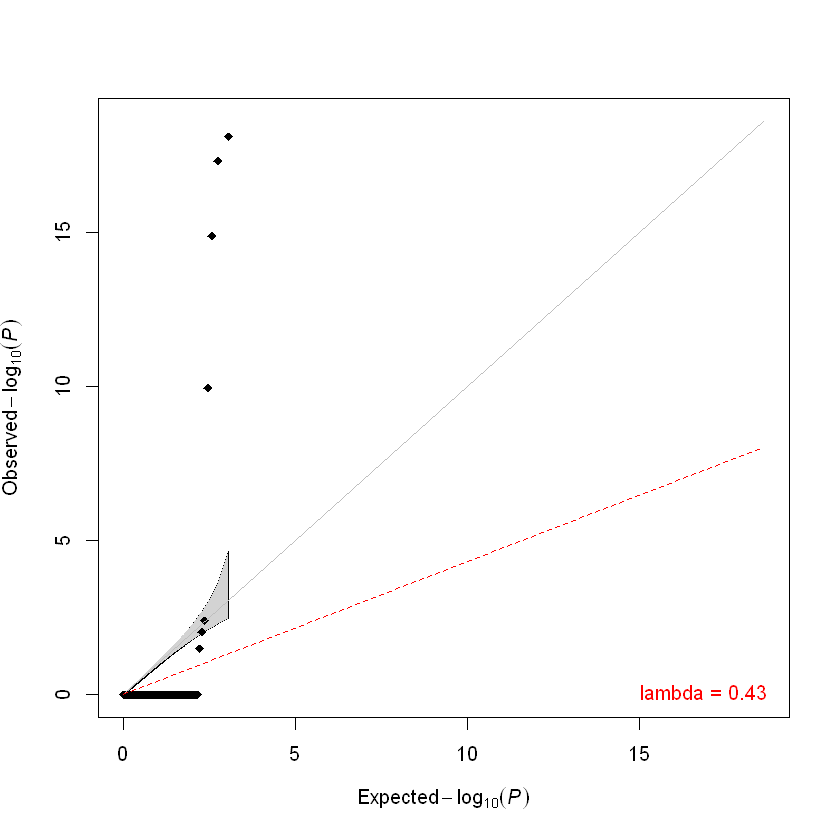

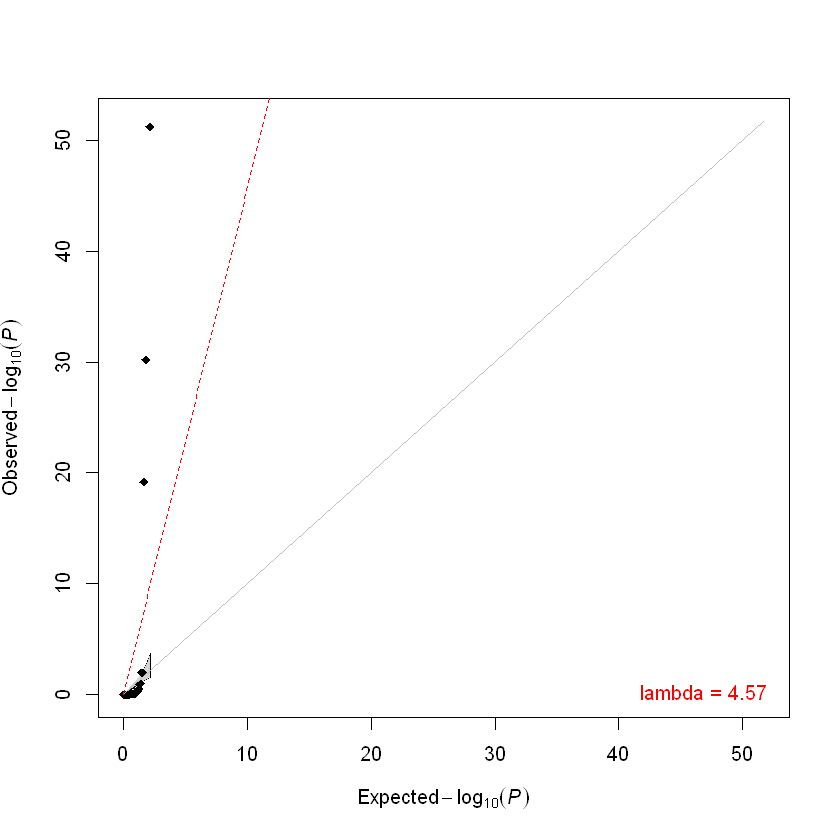

In [8]:
plot(-1*log10(seq(1,0,-1/length(pvals3)))[1:length(pvals3)],-1*log10(rev(sort(pvals3))),type='l')
source("~/bme/jupyter_data/qq_pval.r")
qq_pval(pvals3adj)
qq_pval(pvals5adj)